In [11]:
import os
from pathlib import Path
from PIL import Image
import time

from miniai.imports import *
from miniai.datasets import *
from miniai.diffusion import *

from diffusers import AutoencoderKL

In [12]:
# Get tiny imagenet from HF
xl,yl = 'image','label'
name = "zh-plus/tiny-imagenet"
dsd = load_dataset(name)

## Save Images from Tiny ImageNet into directory

In [18]:
# Set the output directory
path_data = Path("tiny_imgnet")
path_data.mkdir(exist_ok=True)

start_time = time.time()

for split, ds in dsd.items():
    split_dir = path_data / split
    split_dir.mkdir(exist_ok=True)

    # Save the images in batches
    batch_size = 1000
    for i in range(0, ds.num_rows, batch_size):
        images = [img for img in ds["image"][i:i+batch_size]]
        for j, image in enumerate(images):
            image_path = split_dir/f"{i+j}.jpg"
            image.save(image_path)
        print(f"Saved {split} images {i} to {i+batch_size-1}")

elapsed_time = time.time() - start_time
print(f"Total time: {elapsed_time:.2f} seconds")

Saved train images 0 to 999
Saved train images 1000 to 1999
Saved train images 2000 to 2999
Saved train images 3000 to 3999
Saved train images 4000 to 4999
Saved train images 5000 to 5999
Saved train images 6000 to 6999
Saved train images 7000 to 7999
Saved train images 8000 to 8999
Saved train images 9000 to 9999
Saved train images 10000 to 10999
Saved train images 11000 to 11999
Saved train images 12000 to 12999
Saved train images 13000 to 13999
Saved train images 14000 to 14999
Saved train images 15000 to 15999
Saved train images 16000 to 16999
Saved train images 17000 to 17999
Saved train images 18000 to 18999
Saved train images 19000 to 19999
Saved train images 20000 to 20999
Saved train images 21000 to 21999
Saved train images 22000 to 22999
Saved train images 23000 to 23999
Saved train images 24000 to 24999
Saved train images 25000 to 25999
Saved train images 26000 to 26999
Saved train images 27000 to 27999
Saved train images 28000 to 28999
Saved train images 29000 to 29999
Save

## Save images as tensors

In [ ]:
dataset = next(os.walk(path_data))[1]
chan_3 = torch.ones(3,1,1)

In [53]:
def process_images(img_dir, ten_dir):
    for file in os.listdir(img_dir):

        # Load image
        img_path = os.path.join(img_dir, file)
        img = Image.open(img_path).convert('RGB')
        try:
            # Convert image to tensor
            tensor = chan_3*TF.to_tensor(img)
        except Exception as e:
            raise e
    
        # Save tensor
        ten_filen = os.path.splitext(file)[0] + '.pt'
        ten_path = os.path.join(ten_dir, ten_filen)
        torch.save(tensor, ten_path)

In [55]:
first_time = time.time()

for set in dataset:
    img_dir = path_data/set/"images"
    ten_dir = path_data/set/"tensors"
    os.makedirs(ten_dir, exist_ok=True)
    process_images(img_dir, ten_dir)
    print(f"Completed {set} in {time.time()-first_time} seconds")
    
total_time = time.time() - first_time
print(f"Total time: {total_time:.2f} seconds")

Completed valid in 9.072174072265625 seconds
Completed train in 131.69016885757446 seconds
Total time: 131.69 seconds


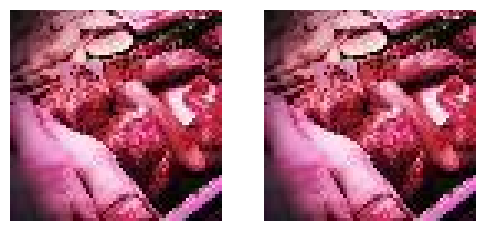

In [63]:
a = path_data/"valid/tensors/3750.pt"
b = path_data/"valid/images/3750.jpg"

img = Image.open(b).convert('RGB')
ten = torch.load(a)

show_images((img, ten))

## Save image features from CLIP model

In [64]:
from transformers import CLIPProcessor, CLIPModel

In [67]:
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to("cuda")

In [ ]:

inputs = processor(images=b[xl], return_tensors="pt", padding=True, do_rescale=False).to("cuda")
image_input = inputs["pixel_values"]
with torch.no_grad():
    image_features = model.get_image_features(image_input)

In [82]:
a = next(os.walk(path_data/"valid/tensors"))[2]
b = len(a)
ten_dir = path_data/"valid/tensors"
number = 3465
print(ten_dir/f"{number}.pt")



tiny_imgnet/valid/tensors/3465.pt


In [ ]:
def tensor_batch(ten_dir, start_int, batch_size):
    ten_list = list()

    for i in range(start_int, batch_size):
        # Load tensor
        ten_path = os.path.join(ten_dir, i)
        print(ten_path/f"{i}.pt")
        ten = torch.load(ten_path+".pt")

        # Append tensor to list
        ten_list.append(ten)

    # Stack list into a batch tensor
    return torch.stack(ten_list, dim=0)
        


def process_image_feats(ten_dir, feat_dir, batch_size=1000):
        num_tens = next(os.walk(ten_dir))[2]
        num_tens = len(num_tens)
        for i in range(0, num_tens, batch_size):
            batch_tensor = tensor_batch(ten_dir, i, batch_size)
            try:
                # Convert tensor batch to image features
                inputs = processor(images=batch_tensor, return_tensors="pt", padding=True, do_rescale=False)
                image_input = inputs["pixel_values"].to("cuda")
                with torch.no_grad():
                    image_features = model.get_image_features(image_input)
            except Exception as e:
                raise e
            
    
        # Save tensor
        ten_filen = os.path.splitext(file)[0] + '.pt'
        ten_path = os.path.join(ten_dir, ten_filen)
        torch.save(tensor, ten_path)

In [ ]:
first_time = time.time()

for set in dataset:
    ten_dir = path_data/set/"tensors"
    feat_dir = path_data/set/"image_features"
    os.makedirs(feat_dir, exist_ok=True)
    process_image_feats(ten_dir, feat_dir)
    print(f"Completed {set} in {time.time()-first_time} seconds")
    
total_time = time.time() - first_time
print(f"Total time: {total_time:.2f} seconds")